In [1]:
# Cotton Weed Detection Challenge
# Environment Setup - Install 3LC and required packages
# Dataset Registration - Create 3LC Tables for data management
# Baseline Training - Train YOLOv8n with run tracking
# Generate Predictions - Create Kaggle submission
# Iterative Improvement - Use 3LC Dashboard to improve data quality

# Reference
# https://www.kaggle.com/code/noorchauhan/cotton-weed-detection-challenge-starter-notebook

In [2]:
!pip install 3lc
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

In [3]:
!3lc login 38b98507-f5c6-459b-a777-213d41497c86
# !3lc service

3lc: API key written to: /root/.config/3LC/api_key.txt
3lc: API key verified.
3lc: Workspace: Kodjo Josué AYITEY's workspace


In [4]:
# Environment Setup & Dataset Registration

In [5]:
# Import required packages
import torch
import tlc
from pathlib import Path
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Check environment
print("Environment Check:\n")
print(f"PyTorch version: {torch.__version__}")
print(f"3LC version: {tlc.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB"
    )
else:
    print("!!! No GPU detected - training will be slower on CPU")

print("\nAll systems ready! Let's begin.")

Environment Check:

PyTorch version: 2.6.0+cu124
3LC version: 2.20.1.1
CUDA available: True
GPU: Tesla T4
GPU Memory: 14.7 GB

All systems ready! Let's begin.


In [6]:
# Dataset Configuration

In [7]:
from pathlib import Path
import yaml

ROOT = Path("/kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset")

yaml_fixed_path = "/kaggle/working/dataset_fixed.yaml"

data = {
    "path": str(ROOT),
    "train": str("train/images"),
    "val": str("val/images"),
    "test": str("test/images"),
    "nc": 3,
    "names": {
        0: "carpetweed",
        1: "morningglory",
        2: "palmer_amaranth",
    }
}

with open(yaml_fixed_path, "w") as f:
    yaml.dump(data, f)

print("Fixed YAML saved to:", yaml_fixed_path)

Fixed YAML saved to: /kaggle/working/dataset_fixed.yaml


In [8]:
# Set up file paths
WORK_DIR = Path("/kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset")  # Current directory
DATASET_YAML = Path("/kaggle/working/dataset_fixed.yaml") # WORK_DIR / "dataset.yaml"

# Verify paths exist
print("Verifying dataset structure...")
print("=" * 50)

if not DATASET_YAML.exists():
    print(f"Could not find {DATASET_YAML}")
    print(f"Current directory: {Path.cwd()}")
    print("Please make sure dataset.yaml is in the current directory")
    raise FileNotFoundError(f"Dataset config not found: {DATASET_YAML}")

print(f"✅ Dataset config: {DATASET_YAML}")
print(f"✅ Working directory: {WORK_DIR.resolve()}")

# Display dataset configuration
print("\n Dataset Configuration:")
print("-" * 50)
with open(DATASET_YAML, "r") as f:
    config_content = f.read()
    print(config_content)

# Count dataset files
train_images = list((WORK_DIR / "train" / "images").glob("*.jpg"))
train_labels = list((WORK_DIR / "train" / "labels").glob("*.txt"))
val_images = list((WORK_DIR / "val" / "images").glob("*.jpg"))
val_labels = list((WORK_DIR / "val" / "labels").glob("*.txt"))
test_images = list((WORK_DIR / "test" / "images").glob("*.jpg"))

print("\n Dataset Statistics:")
print("-" * 50)
print(f"✅ Training:   {len(train_images)} images, {len(train_labels)} labels")
print(f"✅ Validation: {len(val_images)} images, {len(val_labels)} labels")
print(f"✅ Test: {len(test_images)} images")

Verifying dataset structure...
✅ Dataset config: /kaggle/working/dataset_fixed.yaml
✅ Working directory: /kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset

 Dataset Configuration:
--------------------------------------------------
names:
  0: carpetweed
  1: morningglory
  2: palmer_amaranth
nc: 3
path: /kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset
test: test/images
train: train/images
val: val/images


 Dataset Statistics:
--------------------------------------------------
✅ Training:   542 images, 542 labels
✅ Validation: 133 images, 133 labels
✅ Test: 170 images


In [9]:
# Visual Guide: Target Weed Species

In [10]:
!pip uninstall -y numpy
!pip install numpy --upgrade
!pip uninstall -y matplotlib
!pip install matplotlib

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
  Using cached numpy-2.3.5-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.5-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.3.5 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.3.5 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you 

Finding example images for each weed class...
✓ Found example for Carpetweed: 20200819_NIKOND3300_YL_556.jpg
✓ Found example for Morning Glory: 20200819_iPhoneSE_YL_536.jpg
✓ Found example for Palmer Amaranth: 20200819_NIKOND3300_YL_50.jpg

Displaying example images with bounding boxes...


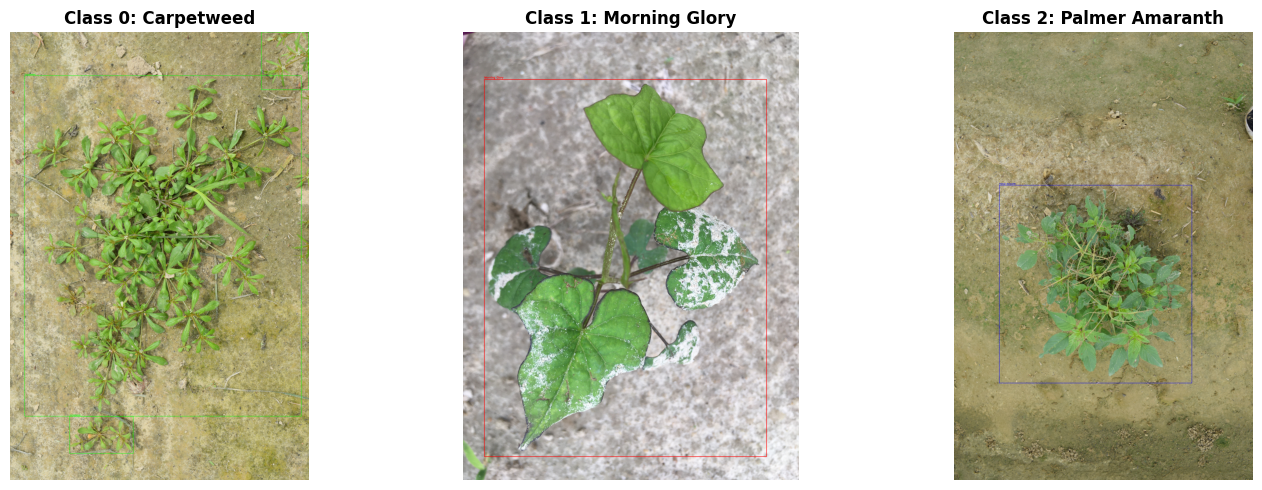


✅ Example images displayed!

 Pro Tip: Keep these visual characteristics in mind when:
   • Analyzing model predictions in the 3LC Dashboard
   • Identifying mislabeled or missing annotations
   • Understanding class confusion patterns


In [11]:
# Example images for each weed class
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

print("Finding example images for each weed class...")
print("=" * 70)

# Set up paths
TRAIN_IMAGES = WORK_DIR / "train" / "images"
TRAIN_LABELS = WORK_DIR / "train" / "labels"
CLASS_NAMES = ["Carpetweed", "Morning Glory", "Palmer Amaranth"]

# Find images containing each class
class_examples = defaultdict(list)

for label_file in TRAIN_LABELS.glob("*.txt"):
    if label_file.stat().st_size > 0:
        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    image_file = TRAIN_IMAGES / f"{label_file.stem}.jpg"
                    if image_file.exists():
                        class_examples[class_id].append(image_file)

# Select one clear example per class (first occurrence)
examples_to_show = {}
for class_id in range(len(CLASS_NAMES)):
    if class_examples[class_id]:
        examples_to_show[class_id] = class_examples[class_id][0]
        print(
            f"✓ Found example for {CLASS_NAMES[class_id]}: {examples_to_show[class_id].name}"
        )
    else:
        print(f"!!!  No examples found for {CLASS_NAMES[class_id]}")

# Display the examples
if examples_to_show:
    print("\n" + "=" * 70)
    print("Displaying example images with bounding boxes...")
    print("=" * 70)

    fig, axes = plt.subplots(1, len(examples_to_show), figsize=(15, 5))
    if len(examples_to_show) == 1:
        axes = [axes]

    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]  # BGR colors for OpenCV

    for idx, (class_id, image_path) in enumerate(sorted(examples_to_show.items())):
        # Read image
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read corresponding label
        label_file = TRAIN_LABELS / f"{image_path.stem}.txt"
        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls = int(parts[0])
                    if cls == class_id:  # Only draw boxes for the target class
                        # Convert YOLO format to pixel coordinates
                        x_center, y_center, box_w, box_h = map(float, parts[1:5])
                        x1 = int((x_center - box_w / 2) * w)
                        y1 = int((y_center - box_h / 2) * h)
                        x2 = int((x_center + box_w / 2) * w)
                        y2 = int((y_center + box_h / 2) * h)

                        # Draw bounding box
                        color = colors[class_id]
                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)

                        # Add class label
                        label_text = f"{CLASS_NAMES[class_id]}"
                        cv2.putText(
                            img,
                            label_text,
                            (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.8,
                            color,
                            2,
                        )

        # Display
        axes[idx].imshow(img)
        axes[idx].set_title(
            f"Class {class_id}: {CLASS_NAMES[class_id]}", fontsize=12, fontweight="bold"
        )
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

    print("\n✅ Example images displayed!")
    print("\n Pro Tip: Keep these visual characteristics in mind when:")
    print("   • Analyzing model predictions in the 3LC Dashboard")
    print("   • Identifying mislabeled or missing annotations")
    print("   • Understanding class confusion patterns")

else:
    print("\n⚠️  Could not find example images for visualization")

In [12]:
# Introduction to 3LC - Data-Centric AI Platform
# Register Your Dataset with 3LC

In [13]:
!rm -rf /root/.local/share/3LC/projects/kaggle_cotton_weed_detection/datasets/
!pip install numpy==1.26.4 pyarrow==10.0.1 tlc-ultralytics

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pyarrow-10.0.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement tlc-ultralytics (from versions: none)
ERROR: No matching distribution found for tlc-ultralytics


In [14]:
# IF RUN THIS CELL FAILED FIRST TIME JUST CLICKED ON THREE DOTS AT DRAFT SESSION LEVEL
# AND "RESTART AND RUN UP TO SELECTED CELL"

# ============================================================================
# Create 3LC Tables from YOLO Format Dataset
# ⚠️ RUN THIS CELL ONLY ONCE (Initial Setup)
# ============================================================================
# This cell registers your dataset with 3LC for version control and analysis.
#
# ⚠️ IMPORTANT FOR RETRAINING:
#    - First time: Run this cell to create tables
#    - Retraining: SKIP this cell and go directly to the next cell
#                  (it loads tables independently without needing this)

# Import required packages
import tlc
from pathlib import Path

# Define constants for 3LC registration
PROJECT_NAME = "kaggle_cotton_weed_detection"
DATASET_NAME = "cotton_weed_competition_dataset"
WORK_DIR = Path("/kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset")
DATASET_YAML = "/kaggle/working/dataset_fixed.yaml" # WORK_DIR / "dataset.yaml"

print("=" * 70)
print("DATA REGISTRATION")
print("=" * 70)

# ============================================================================
# IDEMPOTENCY CHECK - Safe to run multiple times
# ============================================================================
try:
    # Check if tables already exist
    existing_train = tlc.Table.from_names(
        project_name=PROJECT_NAME,
        dataset_name=DATASET_NAME,
        table_name=f"{DATASET_NAME}-train1",
    )
    existing_val = tlc.Table.from_names(
        project_name=PROJECT_NAME,
        dataset_name=DATASET_NAME,
        table_name=f"{DATASET_NAME}-val1",
    )

    print("\n⚠️  Tables already exist!")
    print(f" Training: {len(existing_train)} samples")
    print(f" Validation: {len(existing_val)} samples")
    print("\n✅ Using existing tables (no duplicates created)")
    print(" This cell is safe to run multiple times!")

    # Set variables for compatibility
    train_table = existing_train
    val_table = existing_val

except Exception:
    # Tables don't exist, create them
    print("\n✅ No existing tables - creating new ones...")

    # Create training table
    print("\n Creating training table...")
    train_table = tlc.Table.from_yolo(
        dataset_yaml_file=str(DATASET_YAML),
        split="train",
        task="detect",
        dataset_name=DATASET_NAME,
        project_name=PROJECT_NAME,
        table_name=f"{DATASET_NAME}-train1",
    )

    # Create validation table
    print(" Creating validation table...")
    val_table = tlc.Table.from_yolo(
        dataset_yaml_file=str(DATASET_YAML),
        split="val",
        task="detect",
        dataset_name=DATASET_NAME,
        project_name=PROJECT_NAME,
        table_name=f"{DATASET_NAME}-val1",
    )

# Display registration results
print("\n✅ Tables created successfully!")
print("=" * 70)
print("\n Training Table:")
print(f"   Samples: {len(train_table)}")
print(f"   URL: {train_table.url}")

print("\n Validation Table:")
print(f"   Samples: {len(val_table)}")
print(f"   URL: {val_table.url}")

print("\n" + "=" * 70)
print("✅ Phase 1 Complete: Dataset Registered with 3LC!")
print("=" * 70)

print("\n Next Steps:")
print("  (Optional) Explore tables in Dashboard: https://dashboard.3lc.ai")

DATA REGISTRATION

✅ No existing tables - creating new ones...

 Creating training table...


Output()

 Creating validation table...


Output()


✅ Tables created successfully!

 Training Table:
   Samples: 542
   URL: /root/.local/share/3LC/projects/kaggle_cotton_weed_detection/datasets/cotton_weed_competition_dataset/tables/cotton_weed_competition_dataset-train1

 Validation Table:
   Samples: 133
   URL: /root/.local/share/3LC/projects/kaggle_cotton_weed_detection/datasets/cotton_weed_competition_dataset/tables/cotton_weed_competition_dataset-val1

✅ Phase 1 Complete: Dataset Registered with 3LC!

 Next Steps:
  (Optional) Explore tables in Dashboard: https://dashboard.3lc.ai


In [15]:
# Train Your Baseline Model

In [16]:
!pip install ultralytics
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install 3lc-ultralytics
!pip install pacmap

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datasets 

In [18]:
# IF RUN THIS CELL FAILED FIRST TIME JUST CLICKED ON THREE DOTS AT DRAFT SESSION LEVEL
# AND "RESTART AND RUN UP TO SELECTED CELL"
# IF IT FAILED AGAIN, JUST RERUN THE CELL

# ============================================================================
# Load Tables + Configure Training
# ============================================================================
# This cell:
#   1. Loads your registered tables (includes any Dashboard edits)
#   2. Sets up training configuration (RUN_NAME, EPOCHS, etc.)
#
# For retraining: Just modify RUN_NAME/EPOCHS and rerun this + next cell!

# Import required packages
import tlc
from tlc_ultralytics import YOLO, Settings

# ============================================================================
# STEP 1: Load Tables for Training
# ============================================================================
# Define 3LC project constants
PROJECT_NAME = "kaggle_cotton_weed_detection"
DATASET_NAME = "cotton_weed_competition_dataset"

print("=" * 70)
print("LOADING TABLES FOR TRAINING")
print("=" * 70)

try:
    # ========================================================================
    # OPTION 1: Load by Name (Recommended - Automatic Latest Version)
    # ========================================================================
    # This automatically loads the latest table version (includes Dashboard edits)

    train_table_latest = tlc.Table.from_names(
        project_name=PROJECT_NAME,
        dataset_name=DATASET_NAME,
        table_name=f"{DATASET_NAME}-train1",
    ).latest()

    val_table_latest = tlc.Table.from_names(
        project_name=PROJECT_NAME,
        dataset_name=DATASET_NAME,
        table_name=f"{DATASET_NAME}-val1",
    ).latest()

    print(
        f"\n✅ Training table loaded: {len(train_table_latest)} samples (latest version)"
    )
    print(
        f"✅ Validation table loaded: {len(val_table_latest)} samples (latest version)"
    )

    # Prepare tables dictionary for training
    tables = {"train": train_table_latest, "val": val_table_latest}

    # ========================================================================
    # OPTION 2: Load by URL (Alternative - Specific Table Version)
    # ========================================================================
    # Comment above and Uncomment below to load specific table URLs from Dashboard instead
    # Use this when you want a specific edited table version, not the latest

    """
    # Get URLs from Dashboard: Click on the Tables tab → Copy URL from the spoecific table info panel to clipboard
    TRAIN_TABLE_URL = "paste_your_train_table_url_here"
    VAL_TABLE_URL = "paste_your_val_table_url_here"
    
    train_table_latest = tlc.Table.from_url(TRAIN_TABLE_URL)
    val_table_latest = tlc.Table.from_url(VAL_TABLE_URL)
    
    tables = {"train": train_table_latest, "val": val_table_latest}
    
    print(f"\n✅ Training table loaded from URL: {len(tables['train'])} samples")
    print(f"✅ Validation table loaded from URL: {len(tables['val'])} samples")
    """

    print("\n" + "=" * 70)
    print("✅ Tables Ready!")
    print("=" * 70)

except Exception as e:
    print(f"\n Error loading tables: {e}")
    print("\n💡 Troubleshooting:")
    print("   1. Make sure you ran Data Registration Cell at least once")
    print("   2. Check that PROJECT_NAME and DATASET_NAME match your setup")
    print("   3. Verify tables exist in Dashboard: https://dashboard.3lc.ai")
    raise

# ============================================================================
# STEP 2: Training Configuration
# ============================================================================

print("\n" + "=" * 70)
print("YOLOV8N TRAINING WITH 3LC TRACKING")
print("=" * 70)

# ============================================================================
# TRAINING CONSTANTS - Change these for each iteration
# ============================================================================
RUN_NAME = "yolov8n_baseline"  # Change for each run (e.g., "v2_fixed_labels")
RUN_DESCRIPTION = "Baseline YOLOv8n with default hyperparameters"

# Hyperparameters (customize these!)
EPOCHS = 50  # Number of training epochs (20)
BATCH_SIZE = 16  # Batch size (adjust based on GPU memory)
IMAGE_SIZE = 640  # Input image size (FIXED by competition rules)
DEVICE = 0  # GPU device (0 for first GPU, 'cpu' for CPU)
WORKERS = 4  # Number of dataloader workers

# Display configuration
print("\n Training Configuration:")
print(f"   Run name: {RUN_NAME}")
print("   Model: YOLOv8n (ONLY model allowed)")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Image size: {IMAGE_SIZE} (FIXED)")
print(f"   Device: GPU {DEVICE}" if DEVICE != "cpu" else "   Device: CPU")

# Display dataset info (already loaded in STEP 1 above)
print("\n Dataset:")
print(f"   Training: {len(tables['train'])} samples")
print(f"   Validation: {len(tables['val'])} samples")

# Create 3LC Settings for run tracking
settings = Settings(
    project_name=PROJECT_NAME,
    run_name=RUN_NAME,
    run_description=RUN_DESCRIPTION,
    image_embeddings_dim=2,
)

print("\n" + "=" * 70)
print("✅ CONFIGURATION COMPLETE!")
print("=" * 70)

print("\n💡 Configuration Summary:")
print(f"   • Tables loaded: {len(tables['train'])} train, {len(tables['val'])} val")
print(f"   • Run name: {RUN_NAME}")
print(f"   • Training for: {EPOCHS} epochs")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Device: GPU {DEVICE}" if DEVICE != "cpu" else "   • Device: CPU")

print("\n Next: Run the cell below to start training!")
print("   (Review the configuration above before proceeding)")



# ============================================================================
# Train the Model
# ============================================================================
# This cell loads YOLOv8n and starts training.
# Make sure you ran the cell above first!
from tlc_ultralytics import YOLO, Settings

print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)

# Load YOLOv8n pretrained model
print("\nLoading YOLOv8n pretrained weights...")
model = YOLO("yolov8n.pt")
print("✅ Model loaded (3M parameters, 6MB size)")

# Train the model with 3LC tracking
print("\n Training in progress...")
print("=" * 70)

results = model.train(
    tables=tables,  # Use 3LC Tables
    name=RUN_NAME,  # Name for saving results (creates runs/detect/{RUN_NAME}/)
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    workers=WORKERS,
    settings=settings,  # 3LC tracking
    val=True,  # Validate during training
    # AUGMENTATION - Uncomment for better performance in later iterations:
    # mosaic=1.0,              # Mosaic augmentation - helps with scale variation
    # copy_paste=0.1,          # Copy-paste - helps with occlusion
    # mixup=0.05,              # Mixup - improves generalization
    # patience=20,             # Early stopping patience
)

print("\n" + "=" * 70)
print("✅ TRAINING COMPLETE!")
print("=" * 70)

print("\n📁 Model Weights Saved:")
print(f"   Best model: runs/detect/{RUN_NAME}/weights/best.pt")
print(f"   Last model: runs/detect/{RUN_NAME}/weights/last.pt")
print("\n Use 'best.pt' for predictions and submissions (highest validation mAP)")

print("\n Next Steps:")
print("   1. Visit 3LC Dashboard: https://dashboard.3lc.ai/")
print("   2. Open your Run to analyze model errors")
print("   3. Identify data issues:")
print("      • False negatives (missed detections)")
print("      • False positives (incorrect predictions)")
print("      • Class confusion")
print("      • Poor localization")
print("   4. Fix data issues in Dashboard")
print("   5. Retrain with improved data!")
print(
    "\nLearn more: https://docs.3lc.ai/3lc/latest/how-to/basics/open-project-table-run.html"
)

LOADING TABLES FOR TRAINING

✅ Training table loaded: 542 samples (latest version)
✅ Validation table loaded: 133 samples (latest version)

✅ Tables Ready!

YOLOV8N TRAINING WITH 3LC TRACKING

 Training Configuration:
   Run name: yolov8n_baseline
   Model: YOLOv8n (ONLY model allowed)
   Epochs: 50
   Batch size: 16
   Image size: 640 (FIXED)
   Device: GPU 0

 Dataset:
   Training: 542 samples
   Validation: 133 samples

✅ CONFIGURATION COMPLETE!

💡 Configuration Summary:
   • Tables loaded: 542 train, 133 val
   • Run name: yolov8n_baseline
   • Training for: 50 epochs
   • Batch size: 16
   • Device: GPU 0

 Next: Run the cell below to start training!
   (Review the configuration above before proceeding)
STARTING TRAINING

Loading YOLOv8n pretrained weights...
✅ Model loaded (3M parameters, 6MB size)

 Training in progress...
Using 3LC Trainer 🌟
Ultralytics 8.3.192 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=F

In [19]:
!zip -r /kaggle/working/output.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/yolo11n.pt (deflated 11%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/yolov8n.pt (deflated 9%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/yolov8n_baseline/ (stored 0%)
  adding: kaggle/working/runs/detect/yolov8n_baseline/train_batch1.jpg (deflated 2%)
  adding: kaggle/working/runs/detect/yolov8n_baseline/train_batch1360.jpg (deflated 7%)
  adding: kaggle/working/runs/detect/yolov8n_baseline/val_batch1_pred.jpg (deflated 10%)
  adding: kaggle/working/runs/detect/yolov8n_baseline/BoxPR_curve.png (deflated 13%)
  adding: kaggle/working/runs/detect/yolov8n_baseline/val_batch1_labels.jpg (deflated 11%)
  adding: kaggle/working/runs/detect/yolov8n_baseline/BoxR_curve.png (deflated 11%)
  adding: kaggle/working/runs/detect/yolov8n_baseline/args.yaml (deflated 52%)
  adding: kaggle/working/runs/detect/yolov8

In [20]:
# Load Model Weights (Optional)
# Always use best.pt for final submissions!

In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [22]:
# ============================================================================
# OPTIONAL: Load Model Weights from Previous Training
# ============================================================================
# Uncomment ONE of the options below to load weights

# OPTION 1: Use the model from the training cell above (DEFAULT)
# If you just ran the training cell, the 'model' variable is already loaded
# → No action needed, skip this cell!
"""
print("Current model status:")
try:
    print(f"✅ Model loaded: {type(model).__name__}")
    print(f"  Using model from training session above")
except NameError:
    print("  No model found from training session")
    print("  You must load weights using one of the options below!")
"""
# OPTION 2: Load the LATEST trained model from runs folder
# Uncomment the ENTIRE block below to auto-load the most recent training run

"""
from tlc_ultralytics import YOLO
from pathlib import Path

# Find the most recent training run
runs_dir = Path("runs/detect")
if runs_dir.exists():
    train_dirs = sorted(runs_dir.glob("train*"), key=lambda x: x.stat().st_mtime, reverse=True)
    if train_dirs:
        latest_weights = train_dirs[0] / "weights" / "best.pt"
        if latest_weights.exists():
            print(f"\nLoading latest model: {latest_weights}")
            print(f"Using weights from Ultralytics run folder: {train_dirs[0]}")
            model = YOLO(str(latest_weights))
            print("✅ Model loaded successfully!")
        else:
            print(f"!!! Weights not found: {latest_weights}")
    else:
        print("!!! No training runs found in runs/detect/")
else:
    print("!!! runs/detect/ directory not found")
"""

# By default, use the model from Cell 11 (training)
print("✓ Using model from Cell 11 training session")
print("  (To load different weights, uncomment one of the options above)")


# OPTION 3: Load SPECIFIC weights (custom path)
# Replace the path with your best model
"""
from tlc_ultralytics import YOLO

# Example paths:
# - "runs/detect/train/weights/best.pt"           # First training run
# - "runs/detect/train2/weights/best.pt"          # Second training run
# - "runs/detect/yolov8n_v3/weights/best.pt"      # Named run

CUSTOM_WEIGHTS_PATH = "runs/detect/train/weights/best.pt"

print(f"\nLoading custom weights: {CUSTOM_WEIGHTS_PATH}")
model = YOLO(CUSTOM_WEIGHTS_PATH)
print("✅ Model loaded successfully!")
"""

# OPTION 4: Load pretrained YOLOv8n (no custom training)
# Use this if you want to test the baseline pretrained model
"""
from tlc_ultralytics import YOLO

print("\nLoading pretrained YOLOv8n (COCO weights)")
model = YOLO("yolov8n.pt")
print("✅ Model loaded successfully!")
print("!!!  Note: This is the pretrained model, not trained on cotton weeds!")
"""

print("\n" + "=" * 70)
print("Ready to generate predictions!")
print("=" * 70)

✓ Using model from Cell 11 training session
  (To load different weights, uncomment one of the options above)

Ready to generate predictions!


In [23]:
# Generate Test Predictions

In [24]:
# Import required packages
from pathlib import Path
import shutil

# Define paths and constants
WORK_DIR = Path("/kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset")
TEST_DIR = WORK_DIR / "test" / "images"
PRED_DIR = Path("predictions")
IMAGE_SIZE = 640  # Competition requirement

# Get list of test images
test_images = list(TEST_DIR.glob("*.jpg"))

# ============================================================================
# SAFER FILE MANAGEMENT - Backup instead of delete
# ============================================================================
if PRED_DIR.exists():
    from datetime import datetime

    # Create timestamped backup instead of deleting
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_dir = Path(f"predictions_backup_{timestamp}")

    print("⚠️  Predictions folder exists. Creating backup...")
    print(f"   Moving to: {backup_dir}")

    shutil.move(str(PRED_DIR), str(backup_dir))

    print(f"✅ Previous predictions backed up: {backup_dir}")
    print("   (Delete old backups manually if not needed)")
else:
    print("✅ No existing predictions found")

print("Generating predictions on test set...")
print("=" * 50)
print(f"Test images: {TEST_DIR}")
print(f"Output directory: {PRED_DIR}")
print(f"Test set size: {len(test_images)} images")

# Run inference
print("\nRunning inference...")
test_results = model.predict(
    source=str(TEST_DIR),
    save=False,  # Don't save annotated images (faster, prevents duplication)
    save_txt=True,  # Save YOLO format predictions
    save_conf=True,  # Include confidence scores
    conf=0,  # Confidence threshold (adjust as needed)
    imgsz=IMAGE_SIZE,
    project=str(PRED_DIR.parent),
    name=PRED_DIR.name,
    exist_ok=False,  # Don't allow overwriting (ensures clean predictions)
)

print("\n----Predictions generated!")

✅ No existing predictions found
Generating predictions on test set...
Test images: /kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset/test/images
Output directory: predictions
Test set size: 170 images

Running inference...

image 1/170 /kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset/test/images/20190613_6062W_CM_29.jpg: 480x640 73 carpetweeds, 124 morningglorys, 103 palmer_amaranths, 37.9ms
image 2/170 /kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset/test/images/20190613_6062W_CM_36.jpg: 640x480 30 carpetweeds, 19 morningglorys, 251 palmer_amaranths, 36.1ms
image 3/170 /kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset/test/images/20190613_6062W_CM_57.jpg: 640x480 22 carpetweeds, 72 morningglorys, 206 palmer_amaranths, 7.2ms
image 4/170 /kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset/test/images/20190613_

In [25]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [26]:
# Analyze Test Predictions

In [27]:
# Import required packages
from pathlib import Path

# Define constants
CLASS_NAMES = ["Carpetweed", "Morning Glory", "Palmer Amaranth"]

# Analyze predictions
PRED_DIR = Path("predictions")  # Must match Cell 21
labels_dir = PRED_DIR / "labels"

if labels_dir.exists():
    print("Test Set Prediction Analysis:")
    print("=" * 50)

    pred_files = list(labels_dir.glob("*.txt"))

    class_counts = {i: 0 for i in range(len(CLASS_NAMES))}
    images_with_preds = 0
    total_detections = 0

    for pred_file in pred_files:
        if pred_file.stat().st_size > 0:
            images_with_preds += 1
            with open(pred_file, "r") as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        if len(parts) >= 6:
                            class_id = int(parts[0])
                            class_counts[class_id] += 1
                            total_detections += 1

    print(f"Total test images: {len(test_images)}")
    print(f"Images with detections: {images_with_preds}")
    print(f"Images with no detections: {len(test_images) - images_with_preds}")
    print(f"Total detections: {total_detections}")

    print("\n Detections by class:")
    for class_id, count in class_counts.items():
        percentage = (count / total_detections * 100) if total_detections > 0 else 0
        print(f"   {CLASS_NAMES[class_id]:20s}: {count:4d} ({percentage:5.1f}%)")

    print("\n----Analysis complete!")
else:
    print("!!!!No predictions found.")

Test Set Prediction Analysis:
Total test images: 170
Images with detections: 170
Images with no detections: 0
Total detections: 51000

 Detections by class:
   Carpetweed          : 27112 ( 53.2%)
   Morning Glory       : 14936 ( 29.3%)
   Palmer Amaranth     : 8952 ( 17.6%)

----Analysis complete!


In [28]:
# Convert to Kaggle Submission Format (Required)

In [29]:
# ============================================================================
# STEP 8: Generate Kaggle Submission By running this cell of code
# ============================================================================
# Import required packages
from pathlib import Path
import pandas as pd

# Define paths
WORK_DIR = Path("/kaggle/input/the-3lc-cotton-weed-detection-challenge/cotton_weed_competition_dataset")  # Current directory
PRED_DIR = Path(
    "predictions"
)  # Prediction directory (change path if you want to convert from a different predictions folder)
TEST_DIR = (
    WORK_DIR / "test" / "images"
)  # Change path if you have the Test images stored Elsewhere


print("=" * 70)
print("GENERATING KAGGLE SUBMISSION")
print("=" * 70)

labels_dir = PRED_DIR / "labels"
output_csv = "submission.csv"

# Get all test images (deduplicate by stem to avoid duplicates from case-insensitive file systems)
test_images_dict = {}  # Use dict to automatically deduplicate by image_id (stem)
for ext in ["*.jpg", "*.jpeg", "*.JPG", "*.JPEG", "*.png", "*.PNG"]:
    for img_path in TEST_DIR.glob(ext):
        image_id = img_path.stem  # filename without extension
        if image_id not in test_images_dict:
            test_images_dict[image_id] = img_path

# Convert to sorted list
test_images_list = [
    test_images_dict[img_id] for img_id in sorted(test_images_dict.keys())
]

print(f"\n✓ Found {len(test_images_list)} test images")
print(f"✓ Looking for predictions in: {labels_dir}")

# Create submission data
submission_data = []
images_with_preds = 0
images_without_preds = 0
total_boxes = 0

for img_path in test_images_list:
    image_id = img_path.stem
    pred_file = labels_dir / f"{image_id}.txt"

    # Check if prediction file exists and has content
    if pred_file.exists() and pred_file.stat().st_size > 0:
        prediction_boxes = []

        with open(pred_file, "r") as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()

                    # YOLO saves as: class xc yc w h conf (confidence is LAST!)
                    # Kaggle needs: class conf xc yc w h (confidence is SECOND!)
                    if len(parts) >= 6:
                        # Reorder values: move confidence from position 5 to position 1
                        class_id = parts[0]
                        conf = parts[5]  # Confidence is at the end in YOLO format
                        xc, yc, w, h = parts[1], parts[2], parts[3], parts[4]
                        box_str = f"{class_id} {conf} {xc} {yc} {w} {h}"
                        prediction_boxes.append(box_str)
                        total_boxes += 1

        if prediction_boxes:
            # Join all boxes with spaces
            prediction_string = " ".join(prediction_boxes)
            images_with_preds += 1
        else:
            prediction_string = "no box"
            images_without_preds += 1
    else:
        # No prediction file or empty file
        prediction_string = "no box"
        images_without_preds += 1

    submission_data.append(
        {"image_id": image_id, "prediction_string": prediction_string}
    )

# Create DataFrame with correct column names (lowercase!)
submission_df = pd.DataFrame(submission_data)
submission_df = submission_df[["image_id", "prediction_string"]]

# Save to CSV
submission_df.to_csv(output_csv, index=False)

# Print statistics
print("\n" + "=" * 70)
print("SUBMISSION STATISTICS")
print("=" * 70)
print(f"Total images:               {len(submission_df)}")
print(f"Images with predictions:    {images_with_preds}")
print(f"Images without predictions: {images_without_preds}")
print(f"Total bounding boxes:       {total_boxes}")
if len(submission_df) > 0:
    print(f"Average boxes per image:    {total_boxes / len(submission_df):.2f}")

# Show sample
print("\n" + "=" * 70)
print("SAMPLE PREDICTIONS")
print("=" * 70)
display(submission_df.head(10))

# Validation
print("\n" + "=" * 70)
print("FORMAT VALIDATION")
print("=" * 70)

# Check format
errors = []
if list(submission_df.columns) != ["image_id", "prediction_string"]:
    errors.append(f"!!! Wrong columns: {list(submission_df.columns)}")
else:
    print("✓ Columns correct: image_id, prediction_string")

if len(submission_df) != len(test_images_list):
    errors.append("!!! Row count mismatch")
else:
    print(f"✓ Row count correct: {len(submission_df)}")

# Validate prediction format (sample first 20)
format_ok = True
for idx in range(min(20, len(submission_df))):
    pred_str = str(submission_df.iloc[idx]["prediction_string"])

    if pred_str == "no box":
        continue

    values = pred_str.split()
    if len(values) % 6 != 0:
        format_ok = False
        break

if format_ok:
    print("✓ All sampled predictions properly formatted (6 values per box)")
else:
    errors.append("!!! Some predictions have wrong format")

if errors:
    print("\n!!! VALIDATION FAILED:")
    for err in errors:
        print(f"  {err}")
else:
    print("\n" + "=" * 70)
print("✅ SUBMISSION READY FOR KAGGLE!")
print("=" * 70)
print(f"\nFile: {output_csv}")
print("\n Upload 'submission.csv' to Kaggle!")
print("\n Tips:")
print("   - Check your score on the public leaderboard")
print("   - You have 3 submissions per day (use them wisely!)")
print("   - Select up to 2 final submissions for judging")

GENERATING KAGGLE SUBMISSION

✓ Found 170 test images
✓ Looking for predictions in: predictions/labels

SUBMISSION STATISTICS
Total images:               170
Images with predictions:    170
Images without predictions: 0
Total bounding boxes:       51000
Average boxes per image:    300.00

SAMPLE PREDICTIONS


,image_id,prediction_string
0,20190613_6062W_CM_29,1 0.935422 0.48673 0.481017 0.359838 0.734136 ...
1,20190613_6062W_CM_36,2 0.979274 0.558555 0.678021 0.80131 0.592832 ...
2,20190613_6062W_CM_57,2 0.873601 0.56293 0.959913 0.202485 0.0801746...
3,20190613_Pixel3aXL_CM_65,1 0.876935 0.183731 0.878201 0.117575 0.175651...
4,20190718_iPhone7_EB_12,1 0.396645 0.12607 0.064888 0.1619 0.1282 1 0....
5,20200526_iPhone8_CH_15,2 0.909786 0.370205 0.908801 0.178081 0.182398...
6,20200526_iPhone8_CH_17,1 0.486929 0.109631 0.945783 0.218888 0.108435...
7,20200612_iPhone6_11,0 0.864269 0.238621 0.329808 0.294705 0.314183...
8,20200612_iPhone6_B_2,1 0.814257 0.488326 0.414386 0.475461 0.420185...
9,20200612_iPhone6_SY_152,0 0.864269 0.238621 0.329808 0.294705 0.314183...



FORMAT VALIDATION
✓ Columns correct: image_id, prediction_string
✓ Row count correct: 170
✓ All sampled predictions properly formatted (6 values per box)

✅ SUBMISSION READY FOR KAGGLE!

File: submission.csv

 Upload 'submission.csv' to Kaggle!

 Tips:
   - Check your score on the public leaderboard
   - You have 3 submissions per day (use them wisely!)
   - Select up to 2 final submissions for judging


In [32]:
!zip -r /kaggle/working/predictions.zip /kaggle/working/predictions

  adding: kaggle/working/predictions/ (stored 0%)
  adding: kaggle/working/predictions/labels/ (stored 0%)
  adding: kaggle/working/predictions/labels/20200819_NIKOND3300_YL_410.txt (deflated 59%)
  adding: kaggle/working/predictions/labels/20200819_NIKOND3300_YL_327.txt (deflated 59%)
  adding: kaggle/working/predictions/labels/20190613_6062W_CM_36.txt (deflated 59%)
  adding: kaggle/working/predictions/labels/20190613_Pixel3aXL_CM_65.txt (deflated 59%)
  adding: kaggle/working/predictions/labels/20200625_NIKOND3300_YL_401.txt (deflated 59%)
  adding: kaggle/working/predictions/labels/20200625_NIKOND3300_YL_774.txt (deflated 59%)
  adding: kaggle/working/predictions/labels/20200819_NIKOND3300_YL_940.txt (deflated 59%)
  adding: kaggle/working/predictions/labels/20200624_iPhone6_SY_149.txt (deflated 59%)
  adding: kaggle/working/predictions/labels/20200819_NIKOND3300_YL_855.txt (deflated 59%)
  adding: kaggle/working/predictions/labels/20200819_NIKOND3300_YL_805.txt (deflated 59%)
  ad

In [30]:
# FURTHER IMPROVMENTS

# Augmentation Tuning (Allowed!)
# # Experiment with augmentation hyperparameters:
# model.train(
#     tables=tables,
#     epochs=EPOCHS,
#     # Augmentation params:
#     hsv_h=0.015,      # Hue shifts (lighting changes)
#     hsv_s=0.7,        # Saturation (weather variations)
#     hsv_v=0.4,        # Brightness
#     degrees=10,       # Rotation (camera angles)
#     translate=0.1,    # Position shifts
#     scale=0.5,        # Size variation
#     fliplr=0.5,       # Horizontal flip
#     mosaic=1.0,       # Mosaic augmentation
#     mixup=0.1,        # Mixup augmentation
#     copy_paste=0.1,   # Copy-paste augmentation
# )

# Hyperparameter Tuning (Allowed)
# # Experiment with:
# # - Learning rate: lr0=0.001, 0.005, 0.01, 0.02
# # - Batch size: 8, 16, 32 (GPU memory permitting)
# # - Epochs: 30, 50, 75, 100 (watch for overfitting)
# # - Warmup epochs: warmup_epochs=3, 5, 10
# # - Optimizer: optimizer='Adam', 'AdamW', 'SGD'

# SINCE THE HOST SAID
# You May Optimize:
# Hyperparameters (learning rate, batch size, epochs)
# Training augmentation (mosaic, mixup, rotation, etc.)
# Data quality improvements using 3LC
# Confidence thresholds

In [31]:
# 